<a href="https://colab.research.google.com/github/kush2197/Fixing-Images-using-GANs/blob/master/Fixing_degraded_celebrity_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

You are given the original and degraded versions of a few images. Your task is to write a GAN which can fix the degraded images.

Complete the function `fix` at the end of the "Evaluation" block so that it can take a degraded image, and return a fixed image (that looks as much like the original non-degraded version as possible). Read the doc-string of the fix function to see the format it expects.

Before submission, get this notebook in a state such that the `fix` function can directly be called on an image. Also, please make sure that 5 images are displayed in the result block. Without that, your submission will not be evaluated.

#Setup

## Intended Structure after Setup

Run the blocks in this section to get the following directory structure:
```
/content
│
└───rephrase-pubfig831
    │
    └───correct
    │   │
    │   └───train
    │   │   │
    │   │   └───Adam Sandler
    │   │   │   │   train__000001-000000.jpg
    │   │   │   │   train__000001-000001.jpg
    │   │   │   │   train__000001-000002.jpg
    │   │   │   │   ...
    │   │   │
    │   │   └───Alec Baldwin
    │   │   │   │   train__000002-000000.jpg
    │   │   │   │   train__000002-000001.jpg
    │   │   │   │   ...
    │   │   │
    │   │   └───Angelina Jolie
    │   │   │   │   train__000003-000000.jpg
    │   │   │   │   train__000003-000001.jpg
    │   │   │   │   ...
    │   │   │
    │   │   │ ...
    │   │
    │   └───test
    │       │
    │       └───Adam Sandler
    │       │   │   test__000001-000000.jpg
    │       │   │   test__000001-000001.jpg
    │       │   │   ...
    │       │
    │       └───Alec Baldwin
    │       │   │   test__000002-000000.jpg
    │       │   │   ...
    │       │
    │       └───Angelina Jolie
    │       │   │   test__000003-000000.jpg
    │       │   │   ...
    │       │
    │       │ ...
    │
    │
    └───degraded
        │   <Same directory structure as 'correct'>
```

Every image in the degraded directory is a degraded version of the image with the same name in the correct directory. e.g. `/content/rephrase-pubfig831/degraded/Adam Sandler/train__000001-000002.jpg` is the degraded version of `/content/rephrase-pubfig831/correct/Adam Sandler/train__000001-000002.jpg`

## Installation (pip etc)
Add any other installation commands you want to in this block.

In [0]:
!pip install GPUtil
!pip install tqdm
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install tensorflow==1.14.0

## Downloading and Generating Dataset
Run this block only once. Do not modify it. Also, don't call the degrade function in your code anywhere. You should treat the degradation process as a black box.

In [0]:
import os
from glob import glob

import cv2
import numpy as np
from tqdm import tqdm

def degrade(path: str) -> None:
    """Load image at `input_path`, distort and save as `output_path`"""
    SHIFT = 2
    image = cv2.imread(path)
    to_swap = np.random.choice([False, True], image.shape[:2], p=[.8, .2])
    swap_indices = np.where(to_swap[:-SHIFT] & ~to_swap[SHIFT:])
    swap_vals = image[swap_indices[0] + SHIFT, swap_indices[1]]
    image[swap_indices[0] + SHIFT, swap_indices[1]] = image[swap_indices]
    image[swap_indices] = swap_vals
    cv2.imwrite(path, image)

!wget http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip
!unzip -q pubfig83lfw_raw_in_dirs.zip
!rm pubfig83lfw_raw_in_dirs.zip
!mkdir rephrase-pubfig831
!mv pubfig83lfw_raw_in_dirs rephrase-pubfig831/correct
!rm -r rephrase-pubfig831/correct/distract
!cp -r rephrase-pubfig831/correct rephrase-pubfig831/degraded

for image_path in tqdm(glob('rephrase-pubfig831/degraded/*/*/*.jpg')):
  degrade(image_path)

--2020-04-30 14:22:32--  http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip
Resolving briancbecker.com (briancbecker.com)... 162.241.216.158
Connecting to briancbecker.com (briancbecker.com)|162.241.216.158|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400247922 (382M) [application/zip]
Saving to: ‘pubfig83lfw_raw_in_dirs.zip’

pubfig83lfw_raw_in_ 100%[===================>] 381.71M  78.5MB/s    in 5.1s    

2020-04-30 14:22:37 (74.6 MB/s) - ‘pubfig83lfw_raw_in_dirs.zip’ saved [400247922/400247922]



100%|██████████| 13002/13002 [01:07<00:00, 191.86it/s]


# **Checking Free Memory**
This block is just so that you can have an idea of the resources you have at hand on the Google Collab system.

In [0]:
import psutil
import humanize
import os
import GPUtil as GPU
gpu = GPU.getGPUs()[0]
process = psutil.Process(os.getpid())
print(f"Gen RAM: Free {humanize.naturalsize(psutil.virtual_memory().available)} | Proc size {humanize.naturalsize(process.memory_info().rss)}")
print(f"GPU RAM: Free {gpu.memoryFree:.0f}MB | Used {gpu.memoryUsed:.0f}MB | Util {gpu.memoryUtil*100:.0f}% | Total {gpu.memoryTotal:.0f}MB")

# **Main Code**

## Data Loading

In [0]:
import os
from glob import glob
import cv2
import numpy as np
import tensorflow as tf

files = glob('/content/rephrase-pubfig831/correct/train/*/*')
grid = []

for path in files:
  correct = cv2.imread(path)
  split = path.split('/')
  degraded = cv2.imread('/'.join([*split[:3], 'degraded', *split[4:]]))
  grid.append([np.array(correct),np.array(degraded)])
  
print(len(grid))

## Structure

### **Constants and Hyperparameters**

In [0]:
learning_rate = 0.00002
num_epochs = 20000
batch_size = 1
dis_epochs = 1

### Generator Model

In [0]:
def generator(degen_image):
  x = tf.layers.conv2d(degen_image,64,3,strides=2,padding='same',activation='relu',name ='G1',reuse=tf.AUTO_REUSE)
  x = tf.layers.conv2d(x, 128, 3,padding='same',activation='relu', name = 'G2',reuse=tf.AUTO_REUSE)
  x = tf.layers.conv2d_transpose(x, 64, 3, padding='same',activation='relu', name = 'G3',reuse=tf.AUTO_REUSE)
  x = tf.layers.conv2d_transpose(x, 3, 3, strides=2, padding='same',activation='sigmoid', name = 'G4',reuse=tf.AUTO_REUSE)
  return x

### Discriminator Model

In [0]:
def discriminator(input_image):
  x = tf.layers.conv2d(input_image, 64, 3, strides = 2, padding='same',activation='relu',name = 'D1',reuse=tf.AUTO_REUSE)
  x = tf.layers.conv2d(x, 128, 3, strides = 2, padding = 'same', activation='relu',name = 'D2',reuse=tf.AUTO_REUSE)
  x = tf.layers.conv2d(x, 64, 1, strides = 2, padding = 'same', activation='relu',name = 'D3',reuse=tf.AUTO_REUSE)
  x = tf.layers.flatten(x)
  x = tf.layers.dense(x, 1,activation='sigmoid',name = 'D4',reuse=tf.AUTO_REUSE)
  return x

### Loss Functions

In [0]:
correct_batch = tf.placeholder(np.float64, shape=[None,250,250,3],name='correct_batch')
degraded_batch = tf.placeholder(np.float64, shape=[None,250,250,3],name='degraded_batch')
generated_batch = generator(degraded_batch)

generator_loss = -tf.reduce_mean(tf.math.log(discriminator(generated_batch)))
discriminator_loss = -tf.reduce_mean(tf.math.log(discriminator(correct_batch))+tf.math.log(1-discriminator(generated_batch))+tf.math.log(1-discriminator(degraded_batch)))

### Optimizer

In [0]:
generator_opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
discriminator_opt = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Preprocessing

### Setting device to use for tensor operations

In [0]:
sess = tf.Session()
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='G.*')
dis_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='D.*')

### Initializing weights (if required)

## Training

In [0]:
train_generator = generator_opt.minimize(generator_loss,var_list=gen_vars)
train_discriminator = discriminator_opt.minimize(discriminator_loss,var_list=dis_vars)

In [0]:
import random
import matplotlib.pyplot as plt

sess.run(tf.global_variables_initializer())

#training
print('\n\nTraining GAN for %i epochs................................\n' % num_epochs )
gen_losses = []
dis_losses = []
steps = []
for i in range(1,num_epochs+1):
  sample_indices = random.sample(range(len(grid)),batch_size)
  correct_sample = []
  degraded_sample = []
  for index in sample_indices:
    correct_sample.append((grid[index][0]/255.0).astype('float64'))
    degraded_sample.append((grid[index][1]/255.0).astype('float64'))

  correct_sample = np.asarray(correct_sample)
  degraded_sample = np.asarray(degraded_sample)

  feed_dict = {correct_batch: correct_sample,degraded_batch: degraded_sample}
  generated_sample = sess.run(generated_batch,feed_dict)

  for j in range(1,dis_epochs+1):
    _, dloss = sess.run([train_discriminator, discriminator_loss], feed_dict=feed_dict)

  _, gloss = sess.run([train_generator ,generator_loss], feed_dict = feed_dict)

  if i % 200 == 0 or i == 1:
    print('Epoch %i: Discriminator Loss: %.16f Generator Loss: %.16f' % (i, dloss, gloss))
    gen_losses.append(gloss)
    dis_losses.append(dloss)
    steps.append(i)
  if i % 1000 == 0:
    plt.title("Training error over epochs")
    plt.plot(steps,gen_losses,'r',label = "Generator Loss")
    plt.plot(steps,dis_losses,'b',label = "Discriminator Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    #display sample degraded, generated and correct image
    gen_image_out = generated_sample[0]
    gen_image = np.reshape(gen_image_out * 255, (250,250,3)).astype(np.uint8)
    image = np.row_stack([np.column_stack([grid[sample_indices[0]][1],gen_image,grid[sample_indices[0]][0]])])
    dpi = float(plt.rcParams['figure.dpi'])
    figsize = image.shape[1] / dpi, image.shape[0] / dpi
    ax = plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(image[..., ::-1])
    plt.show()

## Evaluation

In [0]:
def fix(image):
    """
    This function should take a degraded image in BGR format as a 250x250x3
    numpy array with dtype np.uint8, and return its fixed version in the same format.

    Incorrect formats will make the image look completely wrong.
    """
    image = np.array(image)/255.0
    flat_image = np.reshape(image,(1,250,250,3)).astype('float64')
    gen_output = sess.run(generated_batch,feed_dict = {degraded_batch: flat_image})
    gen_image = (gen_output*255).reshape((250,250,3)).astype(np.uint8)
    
    return(gen_image)

# Results
Run this block after done to look at some of the results of the fix function yourself.

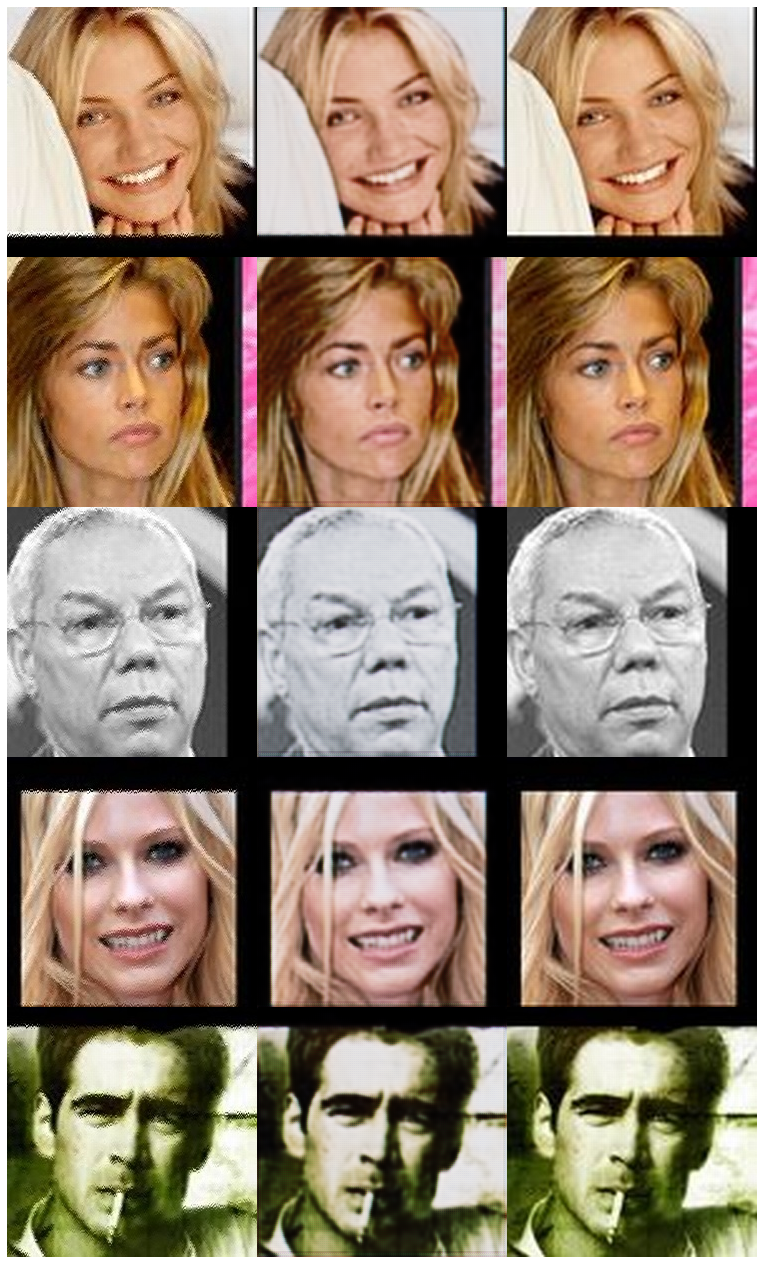

In [0]:
%matplotlib inline

import os
import random
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np

NUM_DISPLAY = 5

files = glob('/content/rephrase-pubfig831/correct/test/*/*')
grid = []

for path in random.sample(files, NUM_DISPLAY):
  correct = cv2.imread(path)
  split = path.split('/')
  degraded = cv2.imread('/'.join([*split[:3], 'degraded', *split[4:]]))
  fixed = fix(degraded)
  grid.append(np.column_stack([degraded, fixed, correct]))

image = np.row_stack(grid)
dpi = float(plt.rcParams['figure.dpi'])
figsize = image.shape[1] / dpi, image.shape[0] / dpi
ax = plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(image[..., ::-1])
plt.show()